# Использование предобученных моделей

Задание: собрать датасет и использовать перенос обучения для решения задачи классификации.

## Порядок выполнения

1. Скачать изображения для создания датасета. Как структурировать папки подсмотрите в работе по ConvNet в датасете с Симпсонами;
1. Подготовить transforms, DataSet и DataLoader;
1. Выбрать одну из моделей в библиотеке timm;
1. Использовать на этой модели прием выделения признаков;
1. Использовать на этой модели прием дообучения (fine-tune);
1. Оценить результаты лучшей модели на тестовой выборке.

## Источники

1. [Туториал от Pytorch](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html)
1. [GitHub pytorch-image-models](https://github.com/huggingface/pytorch-image-models)
1. [Извлечение признаков](https://huggingface.co/docs/timm/feature_extraction)
1. [Which image models are best?](https://www.kaggle.com/code/jhoward/which-image-models-are-best)
1. [Pytorch Image Models (timm)](https://timm.fast.ai/)
1. [huggingface docs timm](https://huggingface.co/docs/hub/timm)

## Создание датасета

В этом задании вам надо собрать собственный датасет из изображений. В нем должно быть минимум 30 изображений для каждого класса. Количество классов не менее 2. Тематику датасета вы выбираете самостоятельно.

Далее в этом разделе приведен пример кода, который помогает скачать изображения по запросу на гугл диск. Вы можете решить эту задачу другими удобными для вас способами, в том числе и вручную.

Если вы работаете с локальной средой, то код из примера придется модифицировать.

In [1]:
# Установка пакета для работы с API поисковика DuckDuckGo

!pip install -U duckduckgo_search

   ---------------------------------------- 0.0/3.2 MB ? eta -:--:--
   ---------------------------------------- 0.0/3.2 MB ? eta -:--:--
   ---------------------------------------- 0.0/3.2 MB ? eta -:--:--
   ---------------------------------------- 0.0/3.2 MB ? eta -:--:--
   ---------------------------------------- 0.0/3.2 MB ? eta -:--:--
   ---------------------------------------- 0.0/3.2 MB ? eta -:--:--
   ---------------------------------------- 0.0/3.2 MB ? eta -:--:--
   ---------------------------------------- 0.0/3.2 MB ? eta -:--:--
   --- ------------------------------------ 0.3/3.2 MB ? eta -:--:--
   --- ------------------------------------ 0.3/3.2 MB ? eta -:--:--
   --- ------------------------------------ 0.3/3.2 MB ? eta -:--:--
   --- ------------------------------------ 0.3/3.2 MB ? eta -:--:--
   --- ------------------------------------ 0.3/3.2 MB ? eta -:--:--
   --- ------------------------------------ 0.3/3.2 MB ? eta -:--:--
   ------ ------------------------

In [5]:
from duckduckgo_search import DDGS
import os
import requests
from PIL import Image, UnidentifiedImageError
from io import BytesIO

In [6]:
animals_list = ['lion', 'zebra', 'rabbit', 'bear', 'cow', 'wolf', 'cat', 'dog', 'horse', 'deer']

# Папки для хранения данных
links_folder = "./animal_links"
dataset_folder = "./animal_dataset"
os.makedirs(links_folder, exist_ok=True)
os.makedirs(dataset_folder, exist_ok=True)

In [8]:
def generate_links(query_list, max_results=50):
    for query in query_list:
        
        links_file = os.path.join(links_folder, f"{query}.txt")
        print(f"Генерация ссылок для {query}, максимум: {max_results}")
        
        with DDGS() as ddgs:
            results = ddgs.images(
                f"{query} photo", region="wt-wt", size="Medium", max_results=max_results
            )
            unique_links = set()
            
            with open(links_file, "w", encoding="utf-8") as f:
                for result in results:
                    link = result.get("image")
                    if link and link not in unique_links:
                        unique_links.add(link)
                        f.write(f"{link}\n")
        
        print(f"Ссылки для {query} сохранены в {links_file}")

generate_links(animals_list, max_results=50)

Генерация ссылок для lion, максимум: 50
Ссылки для lion сохранены в ./animal_links\lion.txt
Генерация ссылок для zebra, максимум: 50
Ссылки для zebra сохранены в ./animal_links\zebra.txt
Генерация ссылок для rabbit, максимум: 50
Ссылки для rabbit сохранены в ./animal_links\rabbit.txt
Генерация ссылок для bear, максимум: 50
Ссылки для bear сохранены в ./animal_links\bear.txt
Генерация ссылок для cow, максимум: 50
Ссылки для cow сохранены в ./animal_links\cow.txt
Генерация ссылок для wolf, максимум: 50
Ссылки для wolf сохранены в ./animal_links\wolf.txt
Генерация ссылок для cat, максимум: 50
Ссылки для cat сохранены в ./animal_links\cat.txt
Генерация ссылок для dog, максимум: 50
Ссылки для dog сохранены в ./animal_links\dog.txt
Генерация ссылок для horse, максимум: 50
Ссылки для horse сохранены в ./animal_links\horse.txt
Генерация ссылок для deer, максимум: 50
Ссылки для deer сохранены в ./animal_links\deer.txt


In [ ]:
def download_images(animals, max_images=30):
    for animal in animals:
        
        links_file = os.path.join(links_folder, f"{animal}.txt")
        output_folder = os.path.join(dataset_folder, animal)
        os.makedirs(output_folder, exist_ok=True)

        if not os.path.exists(links_file):
            print(f"Файл со ссылками для {animal} не найден. Пропускаем...")
            continue

        with open(links_file, "r", encoding="utf-8") as f:
            links = f.readlines()

        count = 0
        for i, link in enumerate(links):
            
            if count >= max_images:
                break
            link = link.strip()
            
            try:
                response = requests.get(link, timeout=10)
                response.raise_for_status()
                img = Image.open(BytesIO(response.content))
                if img.mode in ("RGBA", "P"):
                    img = img.convert("RGB")
                img_path = os.path.join(output_folder, f"{animal}_{i+1}.jpg")
                img.save(img_path, format="JPEG")
                count += 1
                print(f"Скачано: {img_path}")
            
            except (requests.RequestException, UnidentifiedImageError) as e:
                print(f"Ошибка при скачивании {link}: {e}")

download_images(animals_list, max_images=35)

Скачано: ./animal_dataset\lion\lion_1.jpg
Скачано: ./animal_dataset\lion\lion_2.jpg
Скачано: ./animal_dataset\lion\lion_3.jpg
Скачано: ./animal_dataset\lion\lion_4.jpg
Скачано: ./animal_dataset\lion\lion_5.jpg
Скачано: ./animal_dataset\lion\lion_6.jpg
Ошибка при скачивании https://pixfeeds.com/images/1/57614/1200-178449383-barbary-lion.jpg: HTTPSConnectionPool(host='pixfeeds.com', port=443): Max retries exceeded with url: /images/1/57614/1200-178449383-barbary-lion.jpg (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x000002679EAEDA00>: Failed to resolve 'pixfeeds.com' ([Errno 11002] getaddrinfo failed)"))
Скачано: ./animal_dataset\lion\lion_8.jpg
Скачано: ./animal_dataset\lion\lion_9.jpg
Скачано: ./animal_dataset\lion\lion_10.jpg
Скачано: ./animal_dataset\lion\lion_11.jpg
Ошибка при скачивании https://png.pngtree.com/thumb_back/fh260/background/20220917/pngtree-lions-head-power-lion-mouth-photo-image_1170574.jpg: 403 Client Error: Forbidden for url: https

In [3]:
import os
import requests
from PIL import Image, UnidentifiedImageError
from io import BytesIO

def download_images_from_file(links_file, output_folder):
    
    if not os.path.exists(output_folder):
        
        os.makedirs(output_folder)
    
    with open(links_file, "r") as f:
        
        links = f.readlines()

    for i, link in enumerate(links):
        
        try:
            response = requests.get(link.strip(), timeout=5)
            img = Image.open(BytesIO(response.content))
            if img.mode in ("RGBA", "P"):
                img = img.convert("RGB")
            img.save(os.path.join(output_folder, f"image_{i}.jpg"), format="JPEG")

        except UnidentifiedImageError:
            
            print(f"Неверный формат изображения: {link.strip()}")

        except Exception as e:
            
            print(f"Ошибка при скачивании {link.strip()}: {e}")

    print(f"Изображения сохранены в папке {output_folder}.")

# Пример: скачиваем изображения для класса "owl"
download_images_from_file("owl_links.txt", "dataset/owl")


Неверный формат изображения: https://www.allaboutbirds.org/guide/assets/og/75362591-1200px.jpg
Неверный формат изображения: https://abcbirds.org/wp-content/uploads/2022/03/Great-horned-owl-matildamae-shutterstock.jpg
Неверный формат изображения: https://png.pngtree.com/background/20230610/original/pngtree-dark-blue-owl-wallpapers-picture-image_3007725.jpg
Неверный формат изображения: http://upload.wikimedia.org/wikipedia/commons/thumb/b/b0/Masked_owl_mask4441.jpg/220px-Masked_owl_mask4441.jpg
Неверный формат изображения: https://png.pngtree.com/background/20230605/original/pngtree-blue-owl-wallpapers-wallpapers-4k-wallpapers-wallpaper-picture-image_2875094.jpg
Изображения сохранены в папке dataset/owl.


In [ ]:
# монтируем гугл диск к среде, чтобы можно было записывать и считывать изображения
# в постоянное хранилище на гугл диске. Колаб попросит предоставить доступ.

from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# пример создания папки dataset в корне вашего гугл диска
!mkdir "/content/drive/My Drive/dataset"

In [ ]:
# можно посмотреть содержимое файла со ссылками
!cat owl.txt

In [ ]:
# утилита wget построчно читает файл owl.txt и скачивает по URL файлы в папку,
# указанную после флага -P. --random-wait добавляет случайные интервалы между запросами,
# чтобы снизить вероятность блокировки

!wget -i owl.txt --random-wait -P "/content/drive/My Drive/dataset/owl"

### Ответы по датасету (макс. 20 баллов)

В результате работы по этому разделу у вас должен получиться датасет. Проверьте что все скачанные изображения открываются и удалите поврежденные файлы. Изображения стоит разделить в папках на train и test и примерном соотношении 80 и 20%.

Доступ к вашему датасету потребуется открыть. Если вы скачивали изображения локально, то их надо будет выгрузить на гугл или яндекс диск.

**Ссылка на ваш датасет - [https://drive.google.com/drive/folders/11q3Ei-9J03Grug7Y_35ylSblKnlrMXzI?usp=sharing](https://drive.google.com/drive/folders/11q3Ei-9J03Grug7Y_35ylSblKnlrMXzI?usp=sharing)

**Описание вашего датасета:**

* Общее описание решаемой задачи: классификация животных
* Количество классов: 10

---

Ваш ответ:

* Количество изображений в каждом классе в обучающей и тестовой выборках: 

bear (19 - train, 5 - test), cat (28 - train, 7 - test), cow (23 - train, 6 - test), deer (28 - train, 7 - test),  dog (22 - train, 5 - test), horse (23 - train, 6 - test), lion (23 - train, 6 - test), rabbit (18 - train, 5 - test), wolf (26 - train, 7 - test), zebra (28 - train, 7 - test)

## Импортирование модулей

In [11]:
# по необходимости добавляйте свои модули

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision.transforms import v2
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt

%matplotlib inline

In [12]:
# Использование GPU по желанию

if torch.cuda.is_available():
  device = torch.device('cuda')
  print('Работаем на GPU')
else:
  device = torch.device('cpu')
  print('Работаем на CPU')

# Не забывайте про .to(device)

Работаем на CPU


## Выбор модели из timm

В источниках к заданию, вы найдете список моделей, который выложен на github и [сравнение части моделей из timm](https://www.kaggle.com/code/jhoward/which-image-models-are-best). Вам необходимо остановить свой выбор на одной из них. В списке моделей на github есть ссылки на статьи о них, где можно найти информацию на каком датасете они были обучены.

Если вы работаете с фотографиями выбор можно остановить на одной из:
1. MobileNet,
1. VGG,
1. ResNet,
1. Xception.

По желанию можете попробовать несколько и сравнить.


Выбрал MobileNet, потому что она работает в условиях ограниченных ресурсов. Поскольку я работаю на CPU, подходит этой модели

In [14]:
# сначала требуется установить сам модуль timm
!pip install timm

   ---------------------------------------- 0.0/2.4 MB ? eta -:--:--
   ---------------------------------------- 0.0/2.4 MB ? eta -:--:--
   ---------------------------------------- 0.0/2.4 MB ? eta -:--:--
   ---------------------------------------- 0.0/2.4 MB ? eta -:--:--
   ---------------------------------------- 0.0/2.4 MB ? eta -:--:--
   ---------------------------------------- 0.0/2.4 MB ? eta -:--:--
   ---------------------------------------- 0.0/2.4 MB ? eta -:--:--
   ---- ----------------------------------- 0.3/2.4 MB ? eta -:--:--
   ---- ----------------------------------- 0.3/2.4 MB ? eta -:--:--
   ---- ----------------------------------- 0.3/2.4 MB ? eta -:--:--
   -------- ------------------------------- 0.5/2.4 MB 399.6 kB/s eta 0:00:05
   -------- ------------------------------- 0.5/2.4 MB 399.6 kB/s eta 0:00:05
   -------- ------------------------------- 0.5/2.4 MB 399.6 kB/s eta 0:00:05
   ------------- -------------------------- 0.8/2.4 MB 376.9 kB/s eta 0:00:0

ERROR: Could not install packages due to an OSError: [WinError 32] Процесс не может получить доступ к файлу, так как этот файл занят другим процессом: 'C:\\Users\\xiaomi\\AppData\\Local\\Packages\\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\\LocalCache\\local-packages\\Python39\\site-packages\\safetensors\\__init__.pyi'
Check the permissions.



  Using cached timm-1.0.14-py3-none-any.whl.metadata (50 kB)
  Using cached PyYAML-6.0.2-cp39-cp39-win_amd64.whl.metadata (2.1 kB)
  Using cached huggingface_hub-0.27.1-py3-none-any.whl.metadata (13 kB)
  Using cached safetensors-0.5.2-cp38-abi3-win_amd64.whl.metadata (3.9 kB)
Using cached timm-1.0.14-py3-none-any.whl (2.4 MB)
Using cached huggingface_hub-0.27.1-py3-none-any.whl (450 kB)
Using cached PyYAML-6.0.2-cp39-cp39-win_amd64.whl (162 kB)
Using cached safetensors-0.5.2-cp38-abi3-win_amd64.whl (303 kB)


In [15]:
import timm

C:\Users\xiaomi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [16]:
# вывод списка моделей содержащих *resnet* и предобученных

timm.list_models("*mobilenet*", pretrained=True)

['mobilenet_edgetpu_v2_m.ra4_e3600_r224_in1k',
 'mobilenetv1_100.ra4_e3600_r224_in1k',
 'mobilenetv1_100h.ra4_e3600_r224_in1k',
 'mobilenetv1_125.ra4_e3600_r224_in1k',
 'mobilenetv2_050.lamb_in1k',
 'mobilenetv2_100.ra_in1k',
 'mobilenetv2_110d.ra_in1k',
 'mobilenetv2_120d.ra_in1k',
 'mobilenetv2_140.ra_in1k',
 'mobilenetv3_large_100.miil_in21k',
 'mobilenetv3_large_100.miil_in21k_ft_in1k',
 'mobilenetv3_large_100.ra4_e3600_r224_in1k',
 'mobilenetv3_large_100.ra_in1k',
 'mobilenetv3_large_150d.ra4_e3600_r256_in1k',
 'mobilenetv3_rw.rmsp_in1k',
 'mobilenetv3_small_050.lamb_in1k',
 'mobilenetv3_small_075.lamb_in1k',
 'mobilenetv3_small_100.lamb_in1k',
 'mobilenetv4_conv_aa_large.e230_r384_in12k',
 'mobilenetv4_conv_aa_large.e230_r384_in12k_ft_in1k',
 'mobilenetv4_conv_aa_large.e230_r448_in12k_ft_in1k',
 'mobilenetv4_conv_aa_large.e600_r384_in1k',
 'mobilenetv4_conv_blur_medium.e500_r224_in1k',
 'mobilenetv4_conv_large.e500_r256_in1k',
 'mobilenetv4_conv_large.e600_r384_in1k',
 'mobilenet

In [17]:
# в качестве первого аргумента укажите имя выбранной модели
# и не забудьте указать, предобученный вариант (pretrained)
pretrained_model = timm.create_model("mobilenetv2_100", pretrained=True)

C:\Users\xiaomi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\huggingface_hub\file_download.py:140: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\xiaomi\.cache\huggingface\hub\models--timm--mobilenetv2_100.ra_in1k. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


In [18]:
# Вывод архитектуры модели
print(pretrained_model)

EfficientNet(
  (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNormAct2d(
    32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
    (drop): Identity()
    (act): ReLU6(inplace=True)
  )
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn1): BatchNormAct2d(
          32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): ReLU6(inplace=True)
        )
        (aa): Identity()
        (se): Identity()
        (conv_pw): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2): BatchNormAct2d(
          16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): Identity()
        )
        (drop_path): Identity()
      )
    )
    (1): Sequent

В описании архитектуры модели в выводе предыдущей ячейки, найдите два новых модуля (Conv2d, ReLU вы уже знаете) и добавьте их описание. (макс. 15 баллов)

**Ваш ответ:**

1. Модуль *InvertedResidual* - применяется для уменьшения вычислительной сложности. Используются узких входных каналов и расширении их внутри блока.Это позволяет сохранять производительность, используя меньше параметров. модуль также включает в себя сверточные операции *depthwise* и *pointwise* [ссылка](https://towardsdatascience.com/mobilenetv2-inverted-residuals-and-linear-bottlenecks-8a4362f4ffd5) 
1. Модуль *DepthwiseSeparableConv* - разбивает стандартные сверточные операции на две стадии, снижая количество вычислений и делая модель более компактной. Этот модуль разбивает стандартную сверточную операцию на два этапа:

    * Depthwise convolution — применяет сверточный фильтр к каждому входному каналу отдельно.
    * Pointwise convolution — использует сверточный фильтр 1x1 для объединения информации из всех каналов.

**Почему решили выбрать именно эту модель?** (макс. 5 баллов)

Ваш ответ: 

Как я ранее добавил комментарий, модель MobileNet была выбрана за её оптимизацию под ограниченные ресурсы, компактность, высокую производительность и наличие предобученных весов, что значительно упрощает адаптацию под задачу классификации изображений.

## Создание Dataset и DataLoader

По аналогии с прошлыми заданиями нам требуется создать transforms, которые передаются в создаваемый Dataset и из датасета вы создаете DataLoaders.

Данных у нас немного, поэтому мы не будем выделять валидационную часть.

При создании transforms помните, что модель ожидает на вход тензор определенной размерности. В [описание моделей](https://paperswithcode.com/lib/timm), вы можете найти датасет, на котором обучалась модель и есть описание размера изображений.

Для работы вам пригодится:

- v2.ToImage()
- v2.Resize() или v2.RandomResizedCrop() - размер изображения после кадрирования, должен быть равен размеру ожидаемому на ходе предобученной модели.
- v2.RandomRotation()
- v2.RandomHorizontalFlip()
- v2.ToDtype()

[Описания в документации](https://pytorch.org/vision/stable/transforms.html#v2-api-reference-recommended)

In [22]:
# для обучающего набора
train_transforms = v2.Compose([
    v2.RandomResizedCrop(224),  # Обрезка и изменение размера до 224x224
    v2.RandomHorizontalFlip(), # Случайное горизонтальное отражение
    v2.RandomRotation(15),     # Случайный поворот на ±15°
    v2.ToTensor(),             # Преобразование в тензор
    v2.ToDtype(torch.float32)  # Приведение типа
])

# для тестового набора
test_transforms = v2.Compose([
    v2.Resize(256),            # Изменение размера до 256
    v2.CenterCrop(224),        # Центральное обрезание до 224x224
    v2.ToTensor(),             # Преобразование в тензор
    v2.ToDtype(torch.float32)  # Приведение типа
])

Ниже код из гпт для разделения на train и test моего датасета

In [24]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Папка с исходным датасетом
input_folder = "./animal_dataset"
output_folder = "./animal_dataset_split"

# Создаем папки train и test
train_folder = os.path.join(output_folder, "train")
test_folder = os.path.join(output_folder, "test")
os.makedirs(train_folder, exist_ok=True)
os.makedirs(test_folder, exist_ok=True)

# Разделяем изображения по классам
for class_name in os.listdir(input_folder):
    class_path = os.path.join(input_folder, class_name)
    if os.path.isdir(class_path):  # Проверяем, что это папка
        images = os.listdir(class_path)  # Список всех файлов в папке
        train_images, test_images = train_test_split(images, test_size=0.2, random_state=42)

        # Копируем изображения в train
        train_class_folder = os.path.join(train_folder, class_name)
        os.makedirs(train_class_folder, exist_ok=True)
        for img in train_images:
            shutil.copy(os.path.join(class_path, img), os.path.join(train_class_folder, img))

        # Копируем изображения в test
        test_class_folder = os.path.join(test_folder, class_name)
        os.makedirs(test_class_folder, exist_ok=True)
        for img in test_images:
            shutil.copy(os.path.join(class_path, img), os.path.join(test_class_folder, img))

print("Датасет успешно разделен на train и test.")


Датасет успешно разделен на train и test.


In [25]:
train_dataset = ImageFolder(root="./animal_dataset_split/train", transform=train_transforms)
test_dataset = ImageFolder(root="./animal_dataset_split/test", transform=test_transforms)

print(f"Классы: {train_dataset.classes}")
print(f"Количество тренировочных изображений: {len(train_dataset)}")
print(f"Количество тестовых изображений: {len(test_dataset)}")


# Создаем DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)


Классы: ['bear', 'cat', 'cow', 'deer', 'dog', 'horse', 'lion', 'rabbit', 'wolf', 'zebra']
Количество тренировочных изображений: 236
Количество тестовых изображений: 62


Отображение сделал с помощью чат гпт

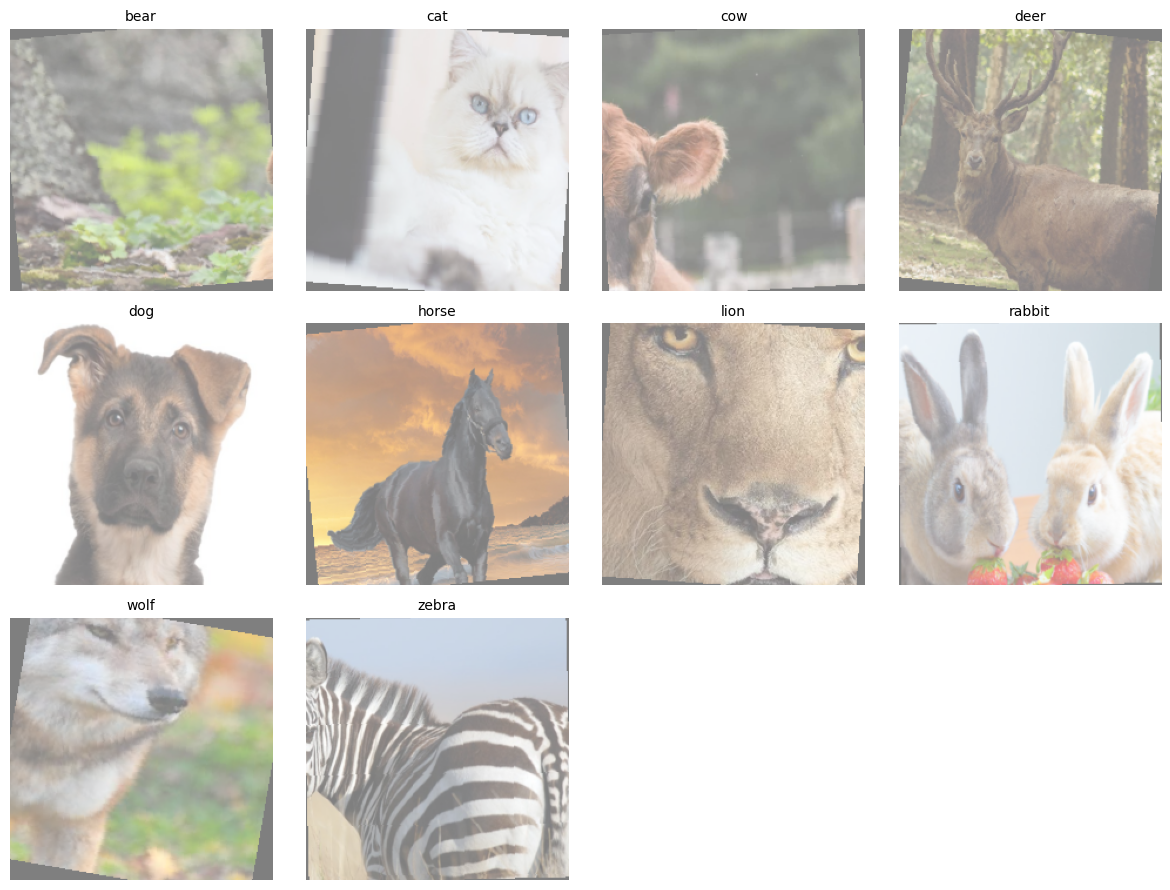

In [29]:
# Карта классов
labels_map = dict(zip(range(len(train_dataset.classes)), train_dataset.classes))

# Функция денормализации изображения
def denormalize(img, mean, std):
    for c in range(3):
        img[c] = img[c] * std[c] + mean[c]
    return img

# Средние и стандартные отклонения (заданные для примера)
mean = [0.5, 0.5, 0.5]
std = [0.5, 0.5, 0.5]

# Количество классов и сетка изображений
num_classes = len(train_dataset.classes)
rows, cols = (num_classes // 4) + 1, 4  # Динамическое определение строк и столбцов
figure = plt.figure(figsize=(12, rows * 3))

# Отображаем по одному изображению из каждого класса
for label in range(num_classes):
    # Находим первое изображение данного класса
    for img, lbl in train_dataset:
        if lbl == label:
            # Денормализация
            img = denormalize(img.clone(), mean, std)
            img = img.permute(1, 2, 0).numpy()  # Перевод в формат (H, W, C)
            break

    # Добавляем подграфик
    ax = figure.add_subplot(rows, cols, label + 1)
    ax.imshow(img)
    ax.set_title(labels_map[label], fontsize=10)
    ax.axis("off")

plt.tight_layout()
plt.show()



**Почему выбрали именно такие преобразования (transforms) для данных?** (макс. 10 баллов)

Ваш ответ:

Для обучающей выборки использовалось случайное кадрирование и изменение размера до 224x224 (RandomResizedCrop(224)), что помогает увеличить вариативность данных и улучшить обобщающую способность модели. 

Случайное горизонтальное отражение (RandomHorizontalFlip()) и поворот на ±15 градусов (RandomRotation(15)) добавляют больше разнообразия и делают модель устойчивой к ориентациям и поворотам объектов. 

Преобразования ToTensor() и ToDtype(torch.float32) были применены для перевода данных в формат тензора PyTorch, подходящий для предобученных моделей. В тестовой выборке использовались минимальные преобразования: изменение размера до 256x256 (Resize(256)) и центральное кадрирование до 224x224 (CenterCrop(224)), чтобы данные соответствовали ожидаемому размеру модели. Эти преобразования обеспечивают корректную оценку качества модели.

## Прием извлечения признаков

Этот прием может использоваться как сам по себе, так и быть предварительным этапом для дообучения.

Он заключается в том, что мы заменяем полносвязную часть модели (head/голову) на свою с учетом размерностей выходных данных из сверточной части и количеством классов в текущей задаче. Перед обучением требуется "заморозить" параметры сверточных слоев.

**Почему требуется "заморозка" параметров?** (макс. 10 баллов)

Ваш ответ:

[ссылка](https://habr.com/ru/articles/467967/)

Заморозка параметров сверточных слоев необходима для того, чтобы ускорить обучение и предотвратить переобучение. Сверточные слои в предобученной модели уже обучены на большом датасете, например, ImageNet, и хорошо извлекают универсальные признаки, такие как края, текстуры и формы. Замораживая их, мы можем сосредоточиться на обучении только последнего слоя (головы), который адаптируется к текущей задаче классификации.




У модели вы можете использовать метод .parameters(), он возвращает итерируемый объект с параметрами вашей модели. Вы можете их перебрать и отключить необходимость расчета градиентов.

In [46]:
# "Замораживаем" веса
for param in pretrained_model.parameters():
    param.requires_grad = False

num_classes = len(train_dataset.classes)

# in_features = pretrained_model.classifier.in_features # Проверяю входные признаки последнего слоя

# Заменяем "голову"
pretrained_model.classifier = nn.Sequential(
    nn.Linear(pretrained_model.classifier[0].in_features, 256), # Промежуточный слой
    nn.ReLU(), # Активация
    nn.Dropout(0.4), # Регуляризация
    nn.Linear(256, num_classes) # Выходной слой
)

print(pretrained_model)

EfficientNet(
  (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNormAct2d(
    32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
    (drop): Identity()
    (act): ReLU6(inplace=True)
  )
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn1): BatchNormAct2d(
          32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): ReLU6(inplace=True)
        )
        (aa): Identity()
        (se): Identity()
        (conv_pw): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2): BatchNormAct2d(
          16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): Identity()
        )
        (drop_path): Identity()
      )
    )
    (1): Sequent

In [48]:
# Функция потерь
loss_fn = nn.CrossEntropyLoss()

# Оптимизатор (учитываем только обучаемые параметры)
optimizer = torch.optim.Adam(pretrained_model.classifier.parameters(), lr=0.001)

В этой работе также рассмотрим применение планировщика для изменения скорости обучения. Ранее у вас скорость обучения была константой, теперь же в процессе обучения каждые n эпох будем ее снижать.



In [49]:
from torch.optim import lr_scheduler

scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [50]:
print(pretrained_model)

EfficientNet(
  (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNormAct2d(
    32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
    (drop): Identity()
    (act): ReLU6(inplace=True)
  )
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn1): BatchNormAct2d(
          32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): ReLU6(inplace=True)
        )
        (aa): Identity()
        (se): Identity()
        (conv_pw): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2): BatchNormAct2d(
          16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): Identity()
        )
        (drop_path): Identity()
      )
    )
    (1): Sequent

### Обучение и тестирование

Несколько эпох обучите модель в таком состоянии. Для обучения используйте уже знакомый вам цикл с эпохами и перебором dataloader, но к нему в цикл эпох требуется добавить шаг планировщика scheduler.step().

Не забывайте переключать режимы моделей (pretrained_model.train(), pretrained_model.eval()), так как теперь в них может быть пакетная нормализация и используйте контекст torch.no_grad() при проверке модели.

In [51]:
num_epochs = 10

pretrained_model.train()

for epoch in range(num_epochs):
  
  running_loss = 0.0
  correct = 0
  total = 0
  
  for images, labels in train_loader:
    
    images = images.to(device)
    labels = labels.to(device)

    # Прямой проход
    outputs = pretrained_model(images)
    loss = loss_fn(outputs, labels)
        
    # Обратный проход
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
        
    # Накопление ошибки
    running_loss += loss.item()

    _, predicted = torch.max(outputs, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

  scheduler.step()

  accuracy = 100 * correct / total
  
  print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}, Accuracy: {accuracy:.2f}%")

pretrained_model.eval()


Epoch [1/10], Loss: 2.1973, Accuracy: 21.61%
Epoch [2/10], Loss: 1.7490, Accuracy: 60.17%
Epoch [3/10], Loss: 1.4355, Accuracy: 62.71%
Epoch [4/10], Loss: 1.0568, Accuracy: 74.15%
Epoch [5/10], Loss: 0.9796, Accuracy: 71.19%
Epoch [6/10], Loss: 0.8319, Accuracy: 80.93%
Epoch [7/10], Loss: 0.7830, Accuracy: 81.78%
Epoch [8/10], Loss: 0.7932, Accuracy: 77.54%
Epoch [9/10], Loss: 0.8156, Accuracy: 78.81%
Epoch [10/10], Loss: 0.7560, Accuracy: 83.47%


EfficientNet(
  (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNormAct2d(
    32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
    (drop): Identity()
    (act): ReLU6(inplace=True)
  )
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn1): BatchNormAct2d(
          32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): ReLU6(inplace=True)
        )
        (aa): Identity()
        (se): Identity()
        (conv_pw): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2): BatchNormAct2d(
          16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): Identity()
        )
        (drop_path): Identity()
      )
    )
    (1): Sequent

## Прием дообучения

Чтобы дообучить модель, требуется разморозить параметры модели. Для упрощения можете разморозить все параметры модели, но более правильно будет разморозить параметры 1-2 последних слоев и оптимизировать их, и наиболее сложный вариант разморозить больше 2 слоев, но использовать сниженные скорости обучения для более ранних слоев модели - [TORCH.OPTIM](https://pytorch.org/docs/stable/optim.html#per-parameter-options).

In [52]:
for param in pretrained_model.blocks[-2:].parameters():
    param.requires_grad = True

In [53]:
# Новый набор объектов

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD([
    {'params': pretrained_model.blocks[-2:].parameters(), 'lr': 1e-4},  # Ниже скорость обучения для размороженных слоев
    {'params': pretrained_model.classifier.parameters(), 'lr': 1e-3}   # Выше скорость обучения для классификатора
], momentum=0.9)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.7)

In [ ]:
num_epochs = 10

pretrained_model.train()

for epoch in range(num_epochs):
  
    running_loss = 0.0
    correct = 0
    total = 0
  
    for images, labels in train_loader:
        
        images = images.to(device)
        labels = labels.to(device)

        # Прямой проход
        outputs = pretrained_model(images)
        loss = loss_fn(outputs, labels)
        
        # Обратный проход
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Накопление ошибки
        running_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    scheduler.step()

    train_accuracy = 100 * correct / total

    # Тестирование
    pretrained_model.eval()
    test_loss = 0.0
    test_correct = 0
    test_total = 0

    with torch.no_grad():
        
        for images, labels in test_loader:
            
            images = images.to(device)
            labels = labels.to(device)

            outputs = pretrained_model(images)
            loss = loss_fn(outputs, labels)
            test_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()

    test_accuracy = 100 * test_correct / test_total

    print(f"Epoch [{epoch+1}/{num_epochs}], "f"Train Loss: {running_loss/len(train_loader):.4f}, Train Accuracy: {train_accuracy:.2f}%, "f"Test Loss: {test_loss/len(test_loader):.4f}, Test Accuracy: {test_accuracy:.2f}%")

pretrained_model.train()


Epoch [1/10], Train Loss: 0.7031, Train Accuracy: 83.90%, Test Loss: 0.7333, Test Accuracy: 82.26%
Epoch [2/10], Train Loss: 0.6214, Train Accuracy: 88.98%, Test Loss: 0.6842, Test Accuracy: 82.26%
Epoch [3/10], Train Loss: 0.4942, Train Accuracy: 89.41%, Test Loss: 0.6224, Test Accuracy: 79.03%
Epoch [4/10], Train Loss: 0.5234, Train Accuracy: 87.29%, Test Loss: 0.5786, Test Accuracy: 82.26%
Epoch [5/10], Train Loss: 0.4635, Train Accuracy: 87.71%, Test Loss: 0.5512, Test Accuracy: 82.26%
Epoch [6/10], Train Loss: 0.3728, Train Accuracy: 90.68%, Test Loss: 0.5320, Test Accuracy: 83.87%
Epoch [7/10], Train Loss: 0.3556, Train Accuracy: 90.25%, Test Loss: 0.5342, Test Accuracy: 82.26%
Epoch [8/10], Train Loss: 0.4053, Train Accuracy: 91.10%, Test Loss: 0.5240, Test Accuracy: 82.26%
Epoch [9/10], Train Loss: 0.3811, Train Accuracy: 89.41%, Test Loss: 0.5112, Test Accuracy: 83.87%
Epoch [10/10], Train Loss: 0.3130, Train Accuracy: 92.80%, Test Loss: 0.5121, Test Accuracy: 83.87%


EfficientNet(
  (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNormAct2d(
    32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
    (drop): Identity()
    (act): ReLU6(inplace=True)
  )
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn1): BatchNormAct2d(
          32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): ReLU6(inplace=True)
        )
        (aa): Identity()
        (se): Identity()
        (conv_pw): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2): BatchNormAct2d(
          16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): Identity()
        )
        (drop_path): Identity()
      )
    )
    (1): Sequent

Скачайте одно новое изображение, которое можно отнести к одному из ваших классов, и классифицируйте его с помощью полученной модели.

## Финал

Осталось попробовать модель на случайном изображении и ответить на вопросы.

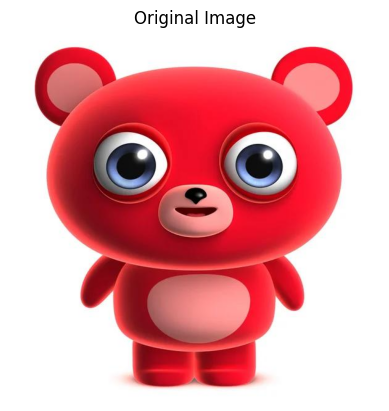

Предсказание: bear


In [ ]:
import torchvision.transforms as T

# import PIL
img_file = "./animal_dataset/bear/bear_28.jpg"
img = Image.open(img_file)

plt.imshow(img)
plt.title("Original Image")
plt.axis("off")
plt.show()

test_transforms = T.transforms.Compose([
    T.transforms.Resize((224, 224)),  
    T.transforms.ToTensor(),
    T.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

img = test_transforms(img)

img = img.unsqueeze(0) 
pretrained_model.eval()

with torch.no_grad():
    outputs = pretrained_model(img.to(device))

_, predicted_class = outputs.max(1)

class_name = train_dataset.classes[predicted_class.item()]

print(f"Предсказание: {class_name}")


**Правильно ли модель классифицировала ваше изображение?** (макс. 10 баллов)

Ваш ответ: верная классификация (проверено на 7 разных изображениях)

**Какая итоговая точность работы вашей модели на тестовой выборке?** (макс. 10 баллов)

Ваш ответ: 83,87%

**Чем отличается прием извлечения признаков от дообучения?** (макс. 20 баллов)

Ваш ответ: 

В первом случае сверточная часть предобученной модели используется как фиксированный инструмент для генерации признаков. Градиенты для этой части не вычисляются, а обучение происходит только для новой "головы". Это быстрый способ адаптировать модель к новой задаче.

Дообучение же включает разморозку всех или части параметров предобученной модели (например, последних слоев). Это позволяет обновлять веса сверточной части модели для лучшего соответствия новой задаче. Дообучение требует большего объема данных и вычислительных ресурсов, но может дать более высокую точность, так как модель адаптируется глубже.